# Aoife Duna and Alec Schneider
# General Assembly Data Science 1-21-2020

This notebook uses the Kiva data set which is part of the "Data Science for Good: Kiva Crowdfunding" Kaggle competition which can be found here: https://www.kaggle.com/kiva/data-science-for-good-kiva-crowdfunding.

Using three different models, we attempt to predict:
1. Whether or not the loan was fully funded
2. If the loan was fully funded, how quickly it was funded
3. If the loan was not fully funded, what percentage of the loan was funded

id: Unique ID for loan
funded_amount: The amount disbursed by Kiva to the field agent(USD)
loan_amount: The amount disbursed by the field agent to the borrower(USD)
activity: More granular category
sector: High level category
use: Exact usage of loan amount
country_code: ISO country code of country in which loan was disbursed
country: Full country name of country in which loan was disbursed
region: Full region name within the country
currency: The currency in which the loan was disbursed
partner_id: ID of partner organization
posted_time: The time at which the loan is posted on Kiva by the field agent
disbursed_time: The time at which the loan is disbursed by the field agent to the borrower
funded_time: The time at which the loan posted to Kiva gets funded by lenders completely
term_in_months: The duration for which the loan was disbursed in months
lender_count: The total number of lenders that contributed to this loan
tags: Hashtags added to the funding request
borrower_genders: Comma separated M,F letters, where each instance represents a single male/female in the group
repayment_interval: Interval at which the loan is expected to be repayed
date

In [89]:
import pandas as pd
import numpy as np

In [90]:
kiva = pd.read_csv('/Users/aoifeduna/AoifeRepo/kiva_loans.csv')

In [91]:
kiva.head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variet...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,11.0,8,NaN,female,irregular,2014-01-01
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,245.0,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,14.0,16,NaN,female,monthly,2014-01-01


In [92]:
# We need to create all of the variables necessary to do our analysis

In [93]:
kiva['funded_time'] = pd.to_datetime(kiva['funded_time'])

In [94]:
kiva['posted_time'] = pd.to_datetime(kiva['posted_time'])

In [95]:
kiva['TimetoFund'] = kiva['funded_time'] - kiva['posted_time']

In [96]:
kiva['TimetoFundMinutes'] = kiva['TimetoFund'] / np.timedelta64(1, 'm')

In [97]:
kiva['PercentFunded'] = kiva['funded_amount'] / kiva['loan_amount']

In [98]:
kiva['TimetoFundMinutes'].fillna(kiva.TimetoFundMinutes.mean(), inplace=True)

In [99]:
kiva['borrower_genders'].fillna("female", inplace=True)
# The mode value is a single female; filling these nulls with the mode

In [100]:
kiva['NumberofBorrowers'] = kiva['borrower_genders'].str.split().str.len()

In [101]:
kiva['NumberofFemaleBorrowers'] = kiva.borrower_genders.str.count("female")

In [102]:
kiva['PercentFemaleBorrowers'] = kiva['NumberofFemaleBorrowers'] / kiva['NumberofBorrowers']

In [103]:
kiva['NumberofTags'] = kiva['tags'].str.split().str.len()

In [104]:
kiva['NumberofTags'].fillna(0, inplace=True)

In [105]:
kiva['CountWordsinDesc'] = kiva['use'].str.split().str.len()

In [106]:
kiva['PostedDayofWeek'] = kiva.posted_time.dt.day_name()

In [107]:
kiva['PostedTimeofDay'] = pd.to_datetime(kiva['posted_time'], format='%H%M%S').dt.hour

In [108]:
kiva['PartnerPresent'] = (kiva.partner_id.values > 0).astype(np.uint8)

/Users/aoifeduna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [109]:
kiva['CountWordsinDesc'].fillna(0, inplace=True)

In [110]:
kiva['LoanFunded'] = (kiva.funded_amount.values > 0).astype(np.uint8)

In [111]:
kiva['LoanFunded'].fillna(0, inplace=True)

In [118]:
# Creating data sets for us to easily call later
X_matrix = kiva.drop(['use','country_code','region', 'currency', 'date', 'TimetoFund', 'tags', 
               'posted_time', 'disbursed_time', 'funded_time', 'NumberofFemaleBorrowers',
               'borrower_genders', 'partner_id', 'TimetoFundMinutes', 'id', 'PercentFunded', 'LoanFunded'], axis=1)
# Dropped these because they are either not additive to the data set or are represented elsewhere

In [119]:
y_matrix = kiva[['LoanFunded', 'PercentFunded', 'TimetoFundMinutes']]

In [120]:
X_matrix.head()

,funded_amount,loan_amount,activity,sector,country,term_in_months,lender_count,repayment_interval,NumberofBorrowers,PercentFemaleBorrowers,NumberofTags,CountWordsinDesc,PostedDayofWeek,PostedTimeofDay,PartnerPresent
0,300.0,300.0,Fruits & Vegetables,Food,Pakistan,12.0,12,irregular,1,1.0,0.0,7.0,Wednesday,6,1
1,575.0,575.0,Rickshaw,Transportation,Pakistan,11.0,14,irregular,2,1.0,0.0,11.0,Wednesday,6,1
2,150.0,150.0,Transportation,Transportation,India,43.0,6,bullet,1,1.0,2.0,17.0,Wednesday,9,1
3,200.0,200.0,Embroidery,Arts,Pakistan,11.0,8,irregular,1,1.0,0.0,12.0,Wednesday,8,1
4,400.0,400.0,Milk Sales,Food,Pakistan,14.0,16,monthly,1,1.0,0.0,4.0,Wednesday,11,1


In [122]:
X_matrix.columns

Index(['funded_amount', 'loan_amount', 'activity', 'sector', 'country',
       'term_in_months', 'lender_count', 'repayment_interval',
       'NumberofBorrowers', 'PercentFemaleBorrowers', 'NumberofTags',
       'CountWordsinDesc', 'PostedDayofWeek', 'PostedTimeofDay',
       'PartnerPresent'],
      dtype='object')

In [129]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from category_encoders import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

ridge, lasso = LinearRegression(), Ridge(), Lasso()
ohe = OneHotEncoder()
sc = StandardScaler()
rf = RandomForestRegressor()

In [130]:
ridge_pipe = make_pipeline(ohe, sc, ridge)
lasso_pipe = make_pipeline(ohe, sc, lasso)
rf_pipe = make_pipeline(ohe, rf)

# Training LoanFunded Classifier

In [2]:
X = pd.read_csv('../KivaLoans_data/X_matrix2.csv')
# X.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
y = pd.read_csv('../KivaLoans_data/y_matrix2.csv')

y = y['loan_funded']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
rf1 = RandomForestClassifier(n_jobs=-1)

In [ ]:
from sklearn.pipeline import Pipeline
rf_pipe = Pipeline([('ohe', ohe), ('rf', rf1)])

In [16]:
rf_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ohe',
                 OneHotEncoder(cols=['activity', 'sector', 'country',
                                     'repayment_interval', 'PostedDayofWeek'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=False, verbose=0)),
                ('rf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_f

In [17]:
rf_pipe.score(X_test, y_test)

0.9615816291057896

In [23]:
feat_imp1 = pd.Series(rf_pipe.steps[1][1].feature_importances_, index=feats1).sort_values(ascending=False)

Text(0.5, 0, 'Feature')

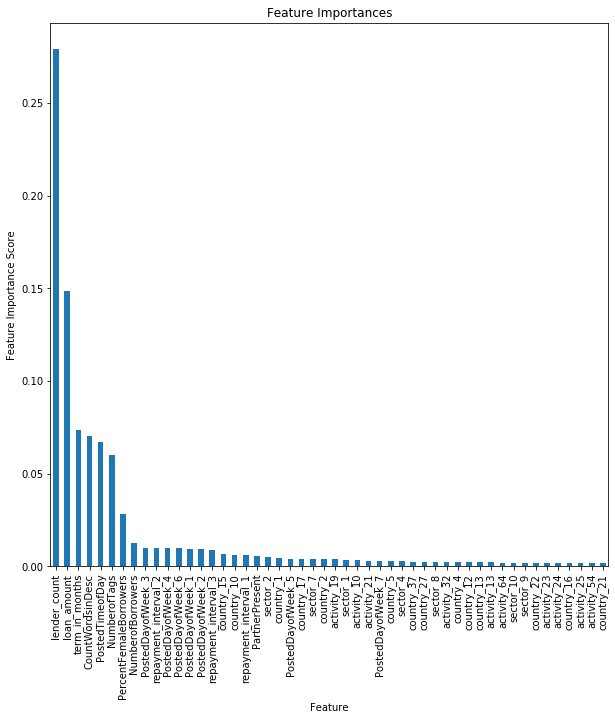

In [24]:
plt.figure(figsize=(10, 10))
feat_imp1[:50].plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.xlabel('Feature')

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [6]:
import xgboost as xgb

xgb1 = xgb.XGBClassifier(n_jobs=-1)

In [11]:
boost_pipe = Pipeline([('ohe', ohe), ('xgbc', xgb1)])

In [12]:
boost_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ohe',
                 OneHotEncoder(cols=['activity', 'sector', 'country',
                                     'repayment_interval', 'PostedDayofWeek'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=False, verbose=0)),
                ('xgbc',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=-1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight

In [ ]:
predicts1 = boost_pipe.predict(X_test)

In [17]:
r2_score(y_test, predicts1)

0.39192012897982187

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5, 0, 'Feature')

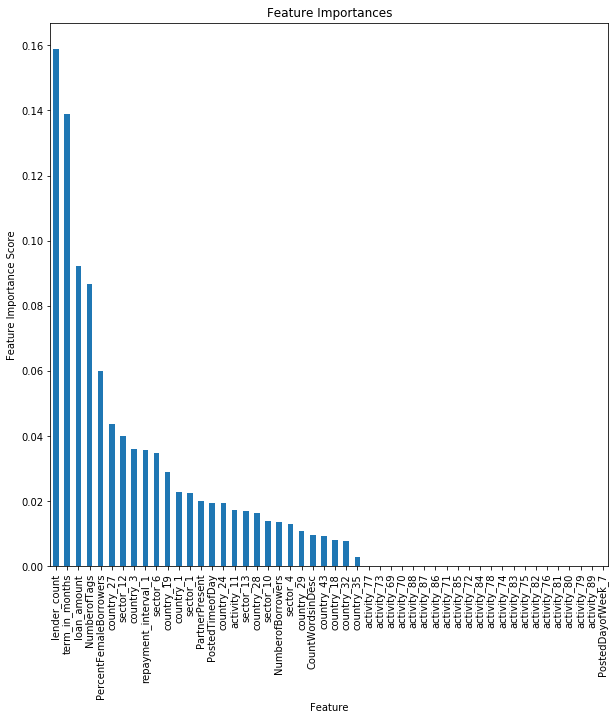

In [20]:
plt.figure(figsize=(10, 10))
feat_imp1[:50].plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.xlabel('Feature')

In [21]:
xgb2 = xgb.XGBClassifier(n_estimators=500, n_jobs=-1)

boost_pipe2= Pipeline([('ohe', ohe), ('xgbc', xgb2)])

In [22]:
boost_pipe2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ohe',
                 OneHotEncoder(cols=['activity', 'sector', 'country',
                                     'repayment_interval', 'PostedDayofWeek'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=False, verbose=0)),
                ('xgbc',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=500, n_jobs=-1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight

In [23]:
predicts2 = boost_pipe2.predict(X_test)

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

In [9]:
import utils
from importlib import reload
reload(utils)

<module 'utils' from 'C:\\Users\\afs95\\MyPython\\KivaLoans\\utils.py'>

# Training TimetoFund Model

In [203]:
Xtime_train, Xtime_test, ytime_train, ytime_test = train_test_split(Xtime, ytime, test_size = .2, random_state=2020)

In [204]:
rf_pipe.fit(Xtime_train, ytime_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('onehotencoder',
                 OneHotEncoder(cols=[], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=False,
                               verbose=0)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, m

In [205]:
leaf_samples = [1, 5, 10, 15, 20]
rf_scores = []

for sample in leaf_samples:
    # Not saying for alpha in alphas, but same concept
    rf_pipe.steps[-1][1].set_params(min_samples_leaf = sample)
    scores = cross_val_score(estimator=rf_pipe, X=Xtime_train, y=ytime_train, cv=10)
    rf_scores.append((np.mean(scores), sample))

In [210]:
rf_scores

[(0.48050303815550216, 1),
 (0.5177407571553895, 5),
 (0.5166642901683819, 10),
 (0.5162360897110821, 15),
 (0.513926105060135, 20)]

In [ ]:
rf2 = RandomForestRegressor(n_estimators=20, min_samples_leaf = 5,random_state=2020, n_jobs = -1)
rf_pipe2 = make_pipeline(ore, ohe, rf)

In [221]:
rf_pipe2.fit(Xtime_train, ytime_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('onehotencoder',
                 OneHotEncoder(cols=[], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=False,
                               verbose=0)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=20, 

In [222]:
rf_pipe2.score(Xtime_test, ytime_test)

0.5118221664221869

# Training PercentFunded Model

In [58]:
Xpct_train, Xpct_test, ypct_train, ypct_test = train_test_split(Xpct, ypct, test_size = .2, random_state=2020)

In [ ]:
pctscores = cross_val_score(estimator=lreg, X=Xpct_train, y=ypct_train, cv=10)
scores

In [59]:
pctscores = cross_val_score(estimator=lreg, X=Xpct_train, y=ypct_train, cv=10)
scores

array([0.51706429, 0.52011791, 0.51468249, 0.51521576, 0.51303315,
       0.51427782, 0.53540193, 0.51508248, 0.53013899, 0.52032734])

In [61]:
ridge_pipe = make_pipeline(ohe, sc, ridge)

In [62]:
ridge_pipe.fit(Xpct_train, ypct_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('onehotencoder',
                 OneHotEncoder(cols=[], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=False,
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ridge',
                 Ridge(alpha=1000.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [63]:
ridge_pipe.score(X_test, y_test)

-1.0897998784742269

In [64]:
lasso_pipe = make_pipeline(ore, ohe, sc, lasso)

In [65]:
lasso_pipe.fit(Xpct_train, ypct_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('onehotencoder',
                 OneHotEncoder(cols=[], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=False,
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lasso',
                 Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=None, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

In [67]:
lasso_pipe.score(Xpct_test, ypct_test)

-2.5387752302652444e-06

In [69]:
leaf_samples = [1, 5, 10, 15]
pct_rf_scores = []

for sample in leaf_samples:
    # Not saying for alpha in alphas, but same concept
    rf_pipe.steps[-1][1].set_params(min_samples_leaf = sample)
    scores = cross_val_score(estimator=rf_pipe, X=Xpct_train, y=ypct_train, cv=10)
    rf_scores.append((np.mean(scores), sample))

In [70]:
pct_rf_scores

[]

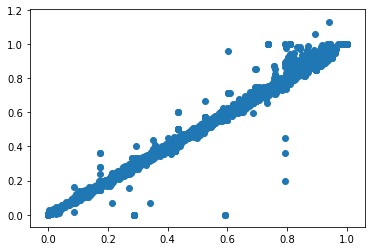

In [71]:
pct_rf_ypred = rf.predict(Xpct_train)
plt.scatter(pct_rf_ypred, ypct_train)